Пример бэктеста простой трендовой стратегии на одном иснтрументе.

Стратегия тестируется на синтетическом непрерывном фьючерсе NQ на CME.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, SGDRegressor
import pandas as pd
import json

Чтение данных:

In [2]:
data = pd.read_csv(f'C:/Users/etsvetkov/algotrading/GC.csv', index_col = 'date')

data.index = pd.to_datetime(data.index, format = "%Y-%m-%dT%H:%M:%SZ")
data.index.name = "timestamp"

data['log_ret'] = np.log(data['close']/data['close'].shift(1))
#Стратегия будет использовать только приросты цен, остальные данные нам не понадобятся
data = data[['log_ret']].dropna()

data_five_t = data[['log_ret']].dropna()


data_five_t.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")
data_five_t = data_five_t.resample("5Min").sum()
data_five_t = data_five_t.dropna()


In [3]:
win = "blackman"

# with open('win.txt', 'r') as file:  
#         # Записываем строку в файл  
#         win = str(file.readline())

# print(win)

Text(0, 0.5, 'NQ 5 timeframe log_ret')

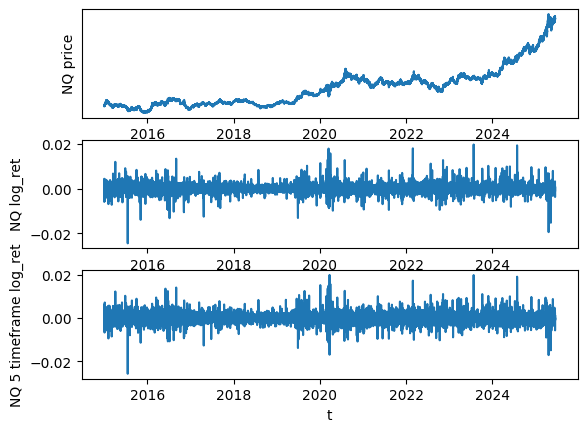

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot((1+data).cumprod())
ax1.set_ylabel('NQ price')
ax1.set_yticks([])
ax2.plot(data)
ax2.set_xlabel('t')
ax2.set_ylabel('NQ log_ret')
ax3.plot(data_five_t)
ax3.set_xlabel('t')
ax3.set_ylabel('NQ 5 timeframe log_ret')

Веделяем выборку для оптимизации и тестовую выборку данных:

In [5]:
days_in_year = 252

def Return(rets):
    """Оценка годовой доходности"""
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """Оценка годовой волатильности"""
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """Оценка годового коэффициента Шарпа"""
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')
        
def statistics_calc(rets, bh, name='_', plot = False):
    """Рисует график эквити портфеля и считает годовые коэф.Шарпа, ретерн и std"""
    sharpe=SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label='strategy')
        plt.plot(bh.cumsum(), label='buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.4f'%sharpe)
        print('Annual Return = %0.4f'%ret)
        print('Annual Std = %0.4f'%vol)
        plt.show()
    return  pd.DataFrame([[sharpe,ret,vol]],columns=['Sharpe ratio','Annual return', 'Volatility'], index =[name]) 
 
def weighted_moving_average(series, window_size):

    #вычисление взвешенного скользящего среднего с использованием Hann window
    hann_window = np.hanning(window_size)
    wma = np.convolve(series, hann_window/hann_window.sum(), mode='valid')

    #добавляем NaN в начале массива, чтобы сместить результат
    return np.concatenate([np.full(window_size-1, np.nan), wma])

In [6]:
def lin_reg(data,params):
    alpha = params[0]
    n_han = params[1]
    fit_intercept = params[2]
    global win

    periods_for_linear_regression = [int(7*(1.45**x)) for x in range(0, n_han)]


    # log_ret = log_ret_norm.loc[data.index[0]: data.index[-1]]
    log_ret = data['log_ret']/np.std(data['log_ret'])

    df = pd.DataFrame(log_ret.values, index=data.index, columns=['value'])

    period_list = []

    for i in periods_for_linear_regression :
        temp = 's_' + str(i)
        # df[temp] = log_ret.ewm(span=i).mean().shift(1) #использование скользящих средних
        df[temp] =  log_ret.rolling(window=i, win_type=win).mean().shift(1)
        period_list.append(temp)

    df = df.dropna()

    # Создание и обучение модели линейной регрессии
    model = Ridge(alpha=alpha, fit_intercept=fit_intercept)

    # Разделение данных на тренировочный и тестовый наборы
    X_train = df[period_list]
    y_train = df['value']


    model.fit(X_train, y_train)

    return model, X_train

def lin_reg_test(data_train,data_test,params):
    alpha = params[0]
    n_han = params[1]
    fit_intercept = params[2]

    periods_for_linear_regression = [int(7*(1.45**x)) for x in range(0, n_han)]

    data = pd.concat([data_train,data_test])
    time_contact = data_train.index[-1]

    # log_ret = log_ret_norm.loc[data.index[0]: data.index[-1]]
    log_ret = data['log_ret']/np.std(data['log_ret'])

    df = pd.DataFrame(log_ret.values, index=data.index, columns=['value'])

    period_list = []

    for i in periods_for_linear_regression :
        temp = 's_' + str(i)
        # df[temp] = log_ret.ewm(span=i).mean().shift(1) #использование скользящих средних
        df[temp] =  df[temp] =  log_ret.rolling(window=i, win_type=win).mean().shift(1)
        period_list.append(temp)

    df = df.dropna()

    # Создание и обучение модели линейной регрессии
    model = Ridge(alpha=alpha, fit_intercept=fit_intercept)

    train_df = df[:time_contact]
    test_df = df[time_contact:]

    # Разделение данных на тренировочный и тестовый наборы
    X_train = train_df[period_list]
    y_train = train_df['value']
    X_test = test_df[period_list]
    y_test = test_df['value']

    model.fit(X_train, y_train)

    return model, X_test

In [7]:
def normalization_position_intraday(row, index, vol_daily):
  time = index.time()
  if time in vol_daily.index:
    return (row['position']/(vol_daily.iloc[time,'vol']))*0.0009
  return (row['position']/0.001657)*0.0009

def strategy_lin_reg(data, par_strat, par_lin, data_train = pd.DataFrame()):
    
    scale = par_strat[0]
    size_1 = par_strat[1]
    size_2 = par_strat[2]
    size_3 = par_strat[3]
    size_4 = par_strat[4]
    pos_limit = 4
    effective_treshold=1.5
    #slippage = (0.0005 if data_train.empty == True else 0.0001)
    slippage = 0.00003

    alpha = par_lin[0]
    n_han = par_lin[1]
    fit_intercept = par_lin[2]

    # Предсказание на тестовом наборе
    if (data_train.empty == True):
        model, X = lin_reg(data,[alpha,n_han, fit_intercept])
    else:
        model, X = lin_reg_test(data_train,data, [alpha,n_han, fit_intercept])

    X = X.resample("5Min").mean().shift(1).fillna(0)
    features=pd.DataFrame(index = X.index) 
        

    features['signal'] = pd.DataFrame(model.predict(X), X.index)
    #Оценка волатильности:
    features['absSignal'] = np.abs(features['signal'])
    features['EmaAbsSignal'] = features['absSignal'].ewm(span=(size_1 * 10)).mean().shift(1)
    features['signal_vol'] = features['EmaAbsSignal'].ewm(span=(size_2 * 100)).mean()+0.00001

    #Оценка волатильности актива:
    features['Ret'] = data['log_ret'].resample("5Min").sum()
    features['absRet'] = np.abs(features['Ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(span=(size_3 * 10)).mean().shift(1)*np.sqrt((size_3 * 10))
    features['vol'] = features['EmaAbsRet'].ewm(span=(size_4 * 100)).mean()*np.sqrt((size_4 * 100))+0.00001 


    
    features['position'] = ((features['signal']/features['signal_vol']/features['vol']/scale).ewm(10).mean().shift(1)).fillna(0).astype(int)
    
    #Добавляем небольшое сглаживание целевой позиции для уменьшения транзакционных издержек
    features['position'] = features['position'].ewm(alpha=0.1).mean()

    #Убираем заглядывание в будущее (мы не можем испольнить ордер по той же цене, по котрой считали сигнал. Нужно брать цену следующего бара)
    features['position'] = features['position'].shift(1)

    #Торгуем целыми лотами
    features['position'] = features['position'].fillna(0).astype(int)

     #гистерезис
    if effective_treshold > 0:
        prev_pos = 0
        # Доступ к значениям напрямую для ускорения
        positions = features['position'].to_numpy()

        for i in range(len(positions)):
            current_pos = positions[i]
            # Проверка изменения позиции в зависимости от предыдущей
            if abs(current_pos - prev_pos) / (abs(prev_pos) + 0.0001) < effective_treshold:
                positions[i] = prev_pos
            # Обнуление позиции при малом значении
            if abs(positions[i]) < effective_treshold:
                positions[i] = 0
            # Обновление предыдущей позиции
            prev_pos = positions[i]

        # Обновляем 'position' в исходном DataFrame
        features['position'] = positions

    
    #features = features.apply(lambda row: normalization_position_intraday(row, row.name), axis=1)

    # positions = features['position'].to_numpy()
    # index = features.index.to_numpy()
    # for i in range(len(positions)):
    #     current_pos = positions[i]
    #     time = pd.to_datetime(index[i]).time()
    #     if time in vol_daily.index:
    #       positions[i] = (positions[i]/(vol_daily.at[time,'vol']))*0.0009
    #     else:
    #       positions[i] = (positions[i]/(0.001657))*0.0009


    #Лимит на максимальную позицию
    features.loc[features.index[features['position']>pos_limit],'position']=int(pos_limit)
    features.loc[features.index[features['position']<-pos_limit],'position']=-int(pos_limit)      

    #Вычисляем эквити кривую и переводим в дневной таймфрейм для расчета основных статистик
    eq = (features['Ret']*features['position']-slippage*features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')
    eq = eq/pos_limit
    bh = data['log_ret'].fillna(0).resample('1D').agg('sum')
    volume = features['position'].diff().abs().sum()
    
    #Считаем статистики и сохраняем результат
    stats=statistics_calc(eq, bh, name="{0}".format(scale)) 
    stats['scale'] = scale

    return stats, eq, bh, volume


Перебор по сетке параметров:

In [8]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def opt_backtest(par_strat, par_lin,data_train):
    stats_current = strategy_lin_reg(data_train, par_strat, par_lin)[0]
    return stats_current['Sharpe ratio'].mean()

def objective(trial,data_train, par_strat):
    alpha = trial.suggest_float("alpha", 1.0, 5.0, log = True)
    n_han = trial.suggest_int("n_han", 2, 10, log = True)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    obj_value = opt_backtest(par_strat, [alpha, n_han, fit_intercept],data_train)

    if np.isnan(obj_value):
        obj_value = 0
    
    return obj_value

def optuna_search(data_train, par_strat):
  study = optuna.create_study(direction = 'maximize')
  study.optimize(lambda trial: objective(trial,data_train, par_strat), n_trials = 100, show_progress_bar = False, n_jobs = 10)

  best_par = list(study.best_params.values())
  # print(best_par)
  return best_par

c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def opt_backtest_strat(par_strat, par_lin,data_train):
    stats_current = strategy_lin_reg(data_train, par_strat, par_lin)[0]
    return stats_current['Sharpe ratio'].mean()

def objective_strat(trial,data_train, par_lin):
    scale = trial.suggest_int("scale", 1, 20, log = True)
    size_1 = trial.suggest_int("size_1", 1, 10, log = True)
    size_2 = trial.suggest_int("size_2", 1, 10, log = True)
    size_3 = trial.suggest_int("size_3", 1, 10, log = True)
    size_4 = trial.suggest_int("size_4", 1, 10, log = True)


    obj_value = opt_backtest_strat([scale,size_1,size_2,size_3,size_4], par_lin,data_train)

    if np.isnan(obj_value):
        obj_value = 0
    
    return obj_value

def optuna_search_strat(data_train,par_lin):
  study = optuna.create_study(direction = 'maximize')
  study.optimize(lambda trial: objective_strat(trial,data_train, par_lin), n_trials = 20, show_progress_bar = False, n_jobs = 4)

  best_par = list(study.best_params.values())
  # print(best_par)
  return best_par

In [10]:
def walk_forward_ridge(data, n_splits, x_train):   
  #train выборка в 1.5 раща больше тестовой
  train_size = int((len(data)//(n_splits+1)) * x_train)

  tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=train_size)

  eq_test = pd.DataFrame()
  bh_test = pd.DataFrame()
  volume_test = 0
  for train_index, test_index in tscv.split(data):  
    # Обучающие и тестовые данные  
    data_train, data_test = data.iloc[train_index], data.iloc[test_index]

    data_train.index = pd.to_datetime(data_train.index, format = "%Y-%m-%d %H:%M:%S")
    data_train = data_train[~data_train.index.duplicated(keep = False)]

    data_test.index = pd.to_datetime(data_test.index, format = "%Y-%m-%d %H:%M:%S")
    data_test = data_test[~data_test.index.duplicated(keep = False)]

    best_par_strat = optuna_search_strat(data_train, [1.5, 10, True])
    best_par_lin = optuna_search(data_train,best_par_strat)

    stats, eq,bh, volume = strategy_lin_reg(data_test, best_par_strat,best_par_lin, data_train)
    volume_test += volume

    # Сохраняем прогнозы  
    eq_test = pd.concat([eq_test, eq])
    bh_test = pd.concat([bh_test, bh])

  return eq_test, bh_test, volume_test

In [13]:
import logging
optuna.logging.set_verbosity(optuna.logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler("optuna.log", mode="w")
formatter = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

optuna.logging.enable_propagation()      
optuna.logging.disable_default_handler()


def opt_backtest_strat1(n_splits, x_train, data_t):
    eq, bh, volume = walk_forward_ridge(data_t, n_splits, x_train)
    eq.columns = ["log_ret"]
    eq.index = pd.to_datetime(eq.index)
    print(n_splits, x_train)
    print(volume)
    stats = statistics_calc(eq['log_ret'],bh,plot=True)
    return stats['Sharpe ratio'].mean()

def objective_strat1(trial,data_t):
    n_splits = trial.suggest_int("n_splits", 3, 300, log = True)
    x_train = trial.suggest_float("x_train", 1.5, 15.0, log = True)
    
    obj_value = opt_backtest_strat1(n_splits,x_train,data_t)

    if np.isnan(obj_value):
        obj_value = 0
    
    return obj_value
def optuna_search_strat1(data_t):
  study = optuna.create_study(direction = 'maximize')
  study.optimize(lambda trial: objective_strat1(trial,data_t), n_trials = 24, show_progress_bar = False, n_jobs = 3)
  best_par = list(study.best_params.values())
  return best_par

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. T

5 5.145016455402274
4042.0
Sharpe ratio = 0.3735
Annual Return = 0.0458
Annual Std = 0.1225


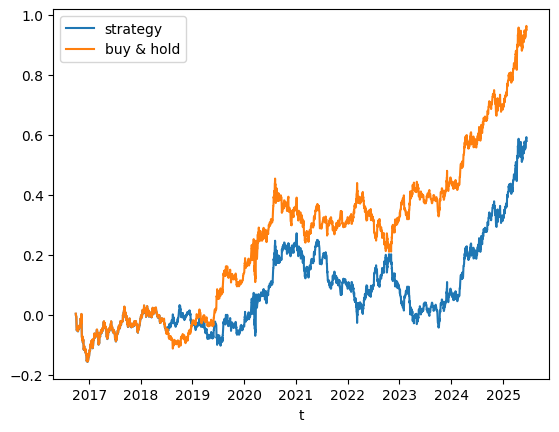

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


7 4.2555656199518
4362.0
Sharpe ratio = 0.1589
Annual Return = 0.0195
Annual Std = 0.1229


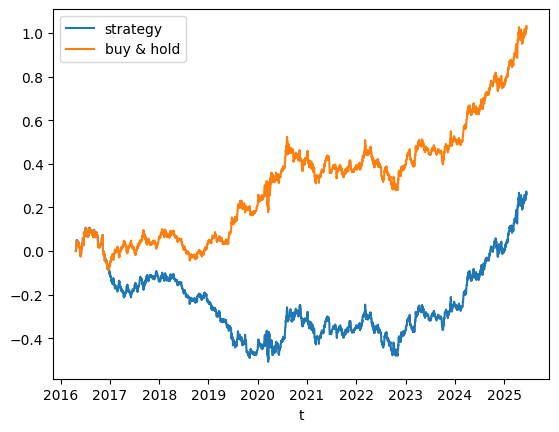

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


29 1.9927476537344704
4256.0
Sharpe ratio = -0.1251
Annual Return = -0.0156
Annual Std = 0.1245


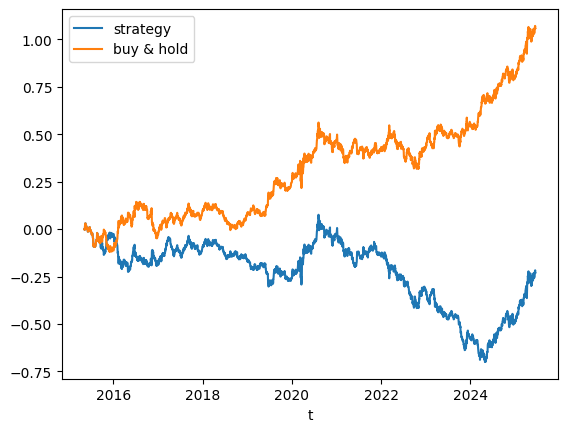

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


4 11.068424103764704
1064.0
Sharpe ratio = -0.0913
Annual Return = -0.0115
Annual Std = 0.1261


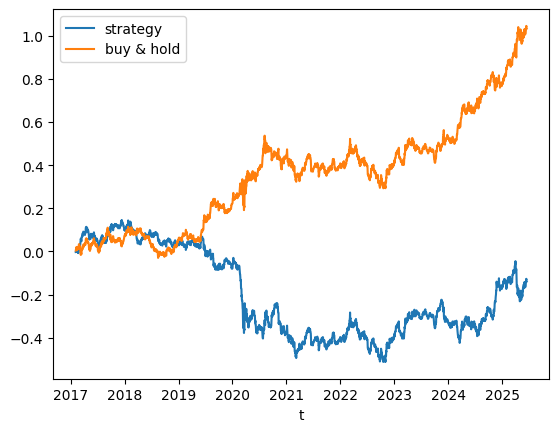

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


29 3.444231171445202
2708.0
Sharpe ratio = 0.4074
Annual Return = 0.0510
Annual Std = 0.1251


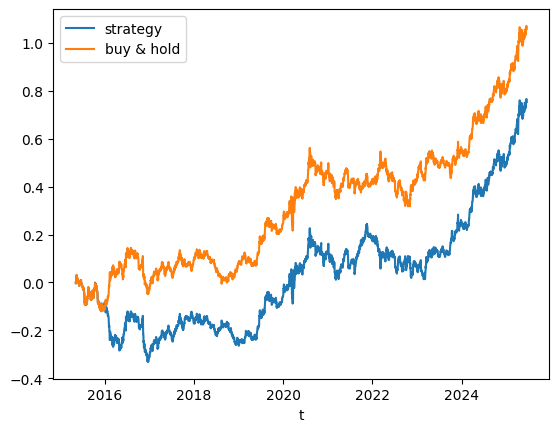

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


7 4.41924022517594
1316.0
Sharpe ratio = 0.2150
Annual Return = 0.0273
Annual Std = 0.1268


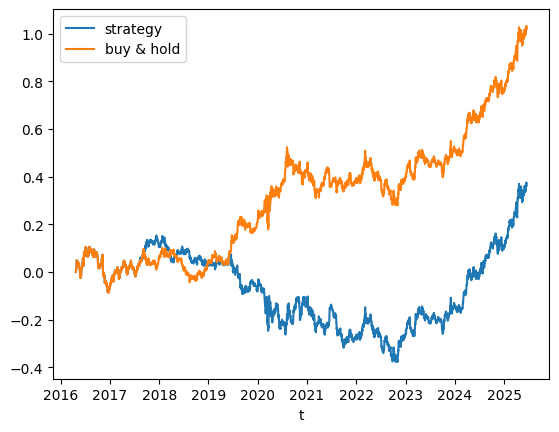

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


13 8.942560752170554
378.0
Sharpe ratio = 0.3201
Annual Return = 0.0406
Annual Std = 0.1269


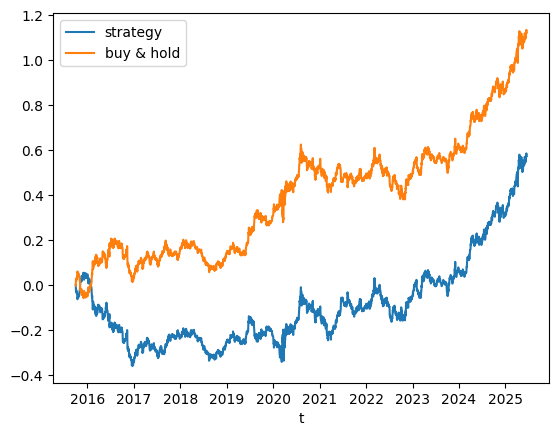

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


61 1.9468230276791516
2904.0
Sharpe ratio = 0.0674
Annual Return = 0.0083
Annual Std = 0.1232


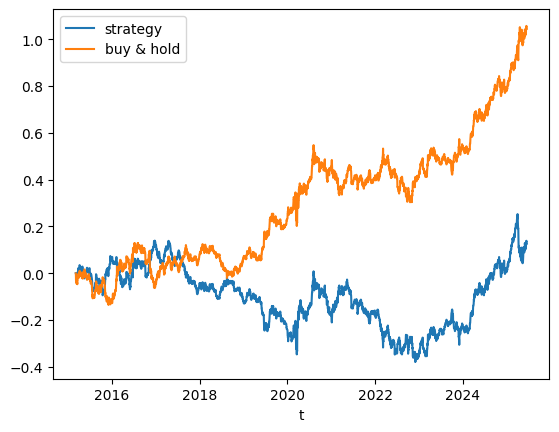

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


3 6.756200579022118
66.0
Sharpe ratio = 0.6720
Annual Return = 0.0862
Annual Std = 0.1282


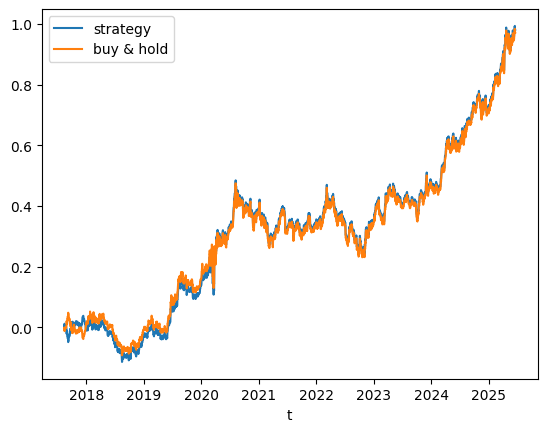

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


17 10.899714470189684
1528.0
Sharpe ratio = 0.3454
Annual Return = 0.0432
Annual Std = 0.1250


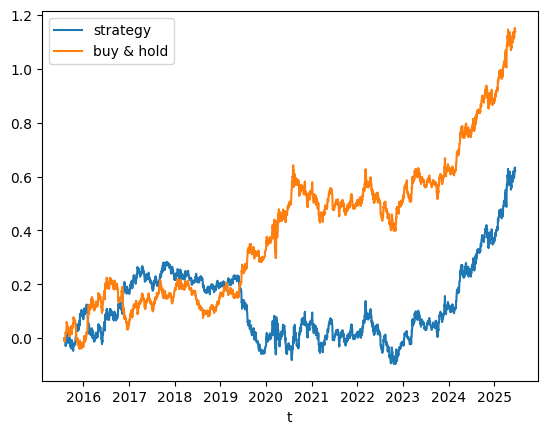

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


17 8.003888349656808
3318.0
Sharpe ratio = 0.3617
Annual Return = 0.0452
Annual Std = 0.1249


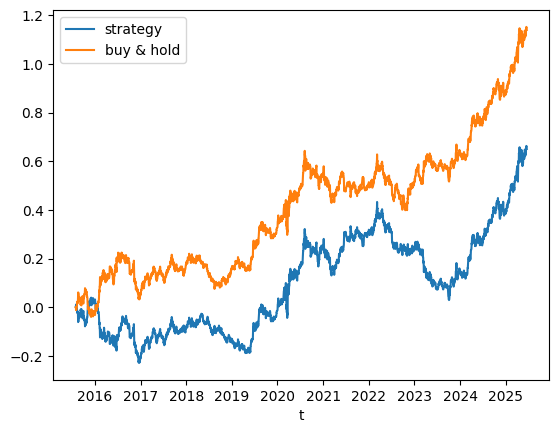

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


149 3.1053302478207896
4090.0
Sharpe ratio = -0.0631
Annual Return = -0.0077
Annual Std = 0.1216


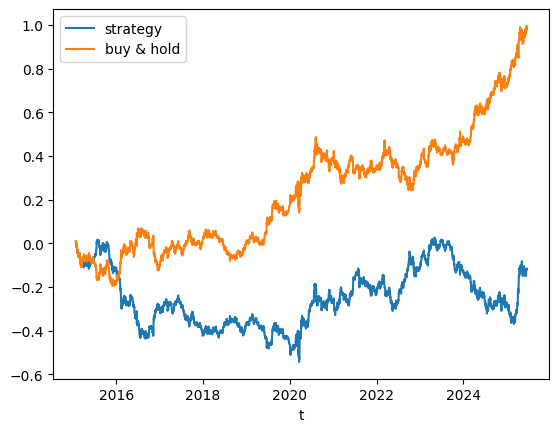

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


298 7.095540721487949
7475.0
Sharpe ratio = 0.1728
Annual Return = 0.0206
Annual Std = 0.1193


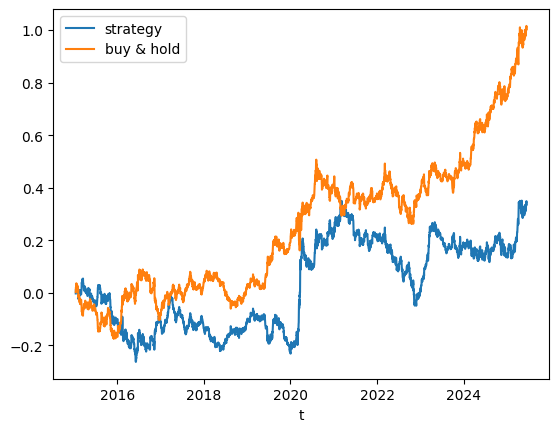

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


201 7.077622996407263
5950.0
Sharpe ratio = 0.1408
Annual Return = 0.0168
Annual Std = 0.1190


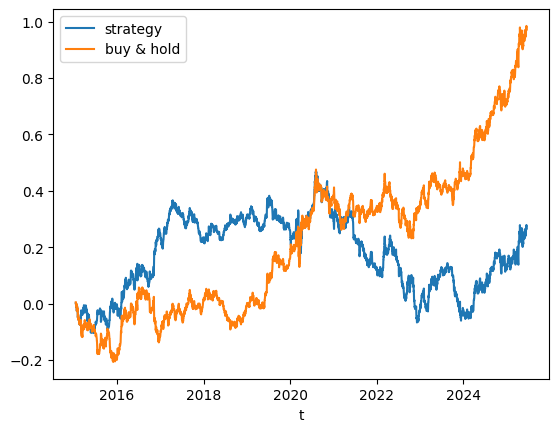

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


50 2.864800692202214
1720.0
Sharpe ratio = 0.1943
Annual Return = 0.0240
Annual Std = 0.1235


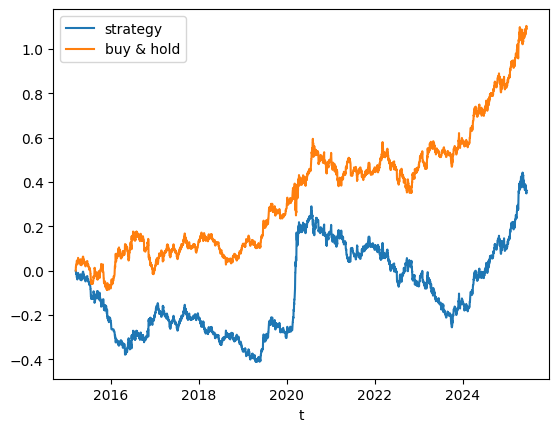

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


3 14.720662079562073
1068.0
Sharpe ratio = 0.5752
Annual Return = 0.0733
Annual Std = 0.1275


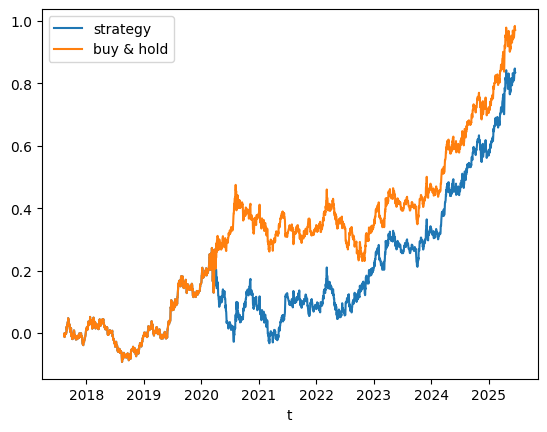

57 6.0307568928513176
4280.0
Sharpe ratio = 0.2652
Annual Return = 0.0326
Annual Std = 0.1230


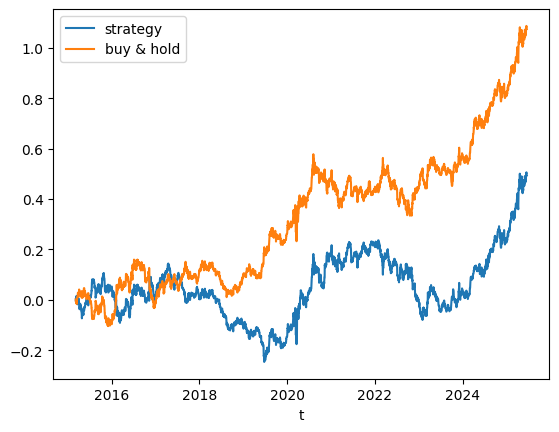

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. T

3 11.639109288853195
3096.0
Sharpe ratio = 0.3044
Annual Return = 0.0364
Annual Std = 0.1195
3 14.355969692780606
308.0
Sharpe ratio = 0.4754
Annual Return = 0.0608
Annual Std = 0.1279


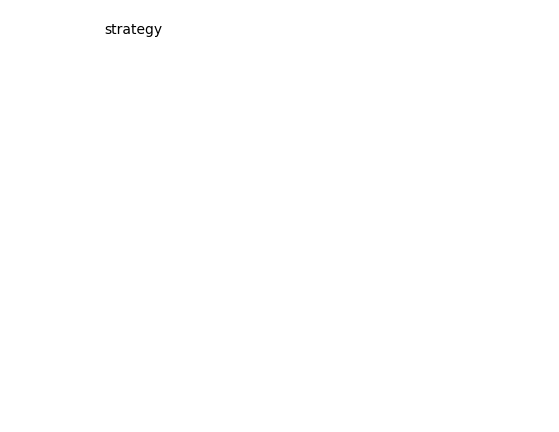

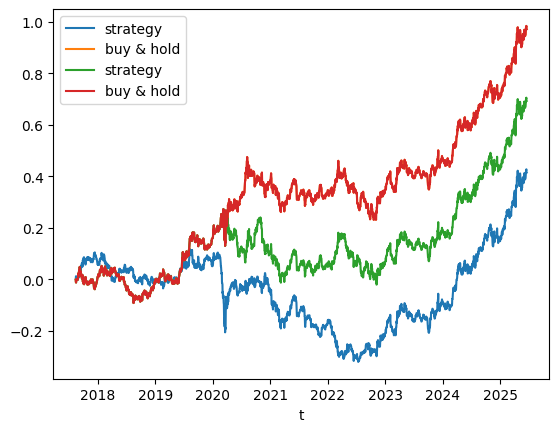

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. T

3 14.35206907140452
490.0
Sharpe ratio = -0.5616
Annual Return = -0.0719
Annual Std = 0.1280


c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


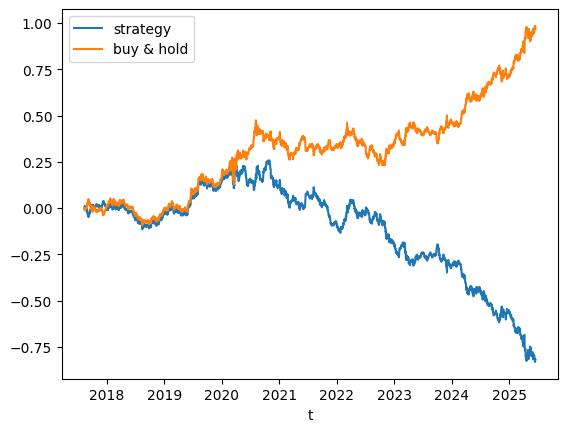

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


7 14.838111267400333
692.0
Sharpe ratio = -0.3574
Annual Return = -0.0451
Annual Std = 0.1263


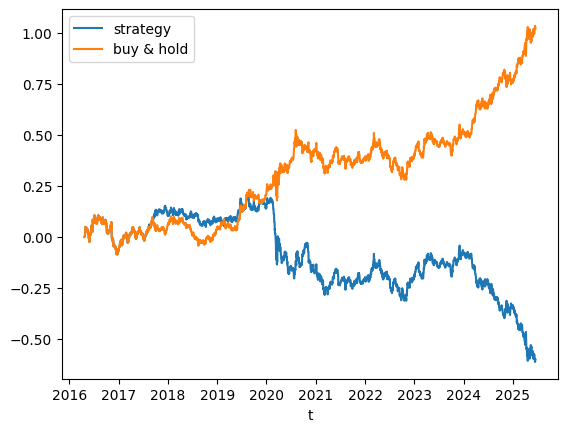

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_12192\1140797317.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


10 1.534417946849882
416.0
Sharpe ratio = 0.4321
Annual Return = 0.0547
Annual Std = 0.1266


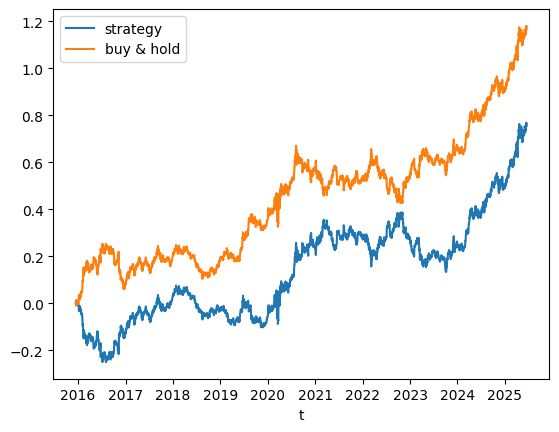

5 10.377101333679487
1166.0
Sharpe ratio = 0.0889
Annual Return = 0.0112
Annual Std = 0.1261


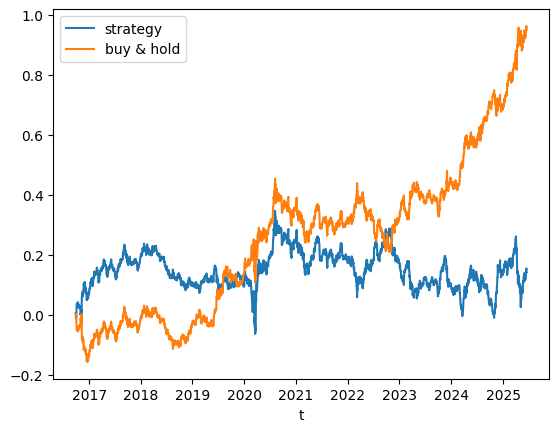

54 3.0184149697294544
2674.0
Sharpe ratio = -0.0770
Annual Return = -0.0096
Annual Std = 0.1245


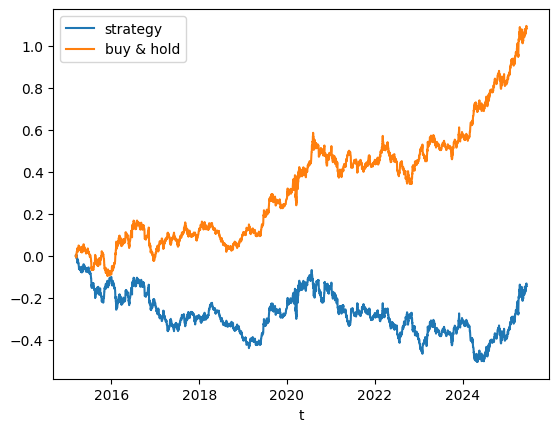

[3, 6.756200579022118]

In [14]:
optuna_search_strat1(data_five_t)